In [16]:
import numpy as np

def average_boxes(boxes, iou_thresh=0.5):
    if len(boxes) == 0:
        return []

    boxes = np.array(boxes)
    keep = []

    while len(boxes) > 0:
        ref_box = boxes[0]
        rest = boxes[1:]

        x1, y1, x2, y2, score = ref_box
        ious = []

        for box in rest:
            xx1 = max(x1, box[0])
            yy1 = max(y1, box[1])
            xx2 = min(x2, box[2])
            yy2 = min(y2, box[3])
            inter = max(0, xx2 - xx1) * max(0, yy2 - yy1)
            union = (x2 - x1) * (y2 - y1) + (box[2] - box[0]) * (box[3] - box[1]) - inter
            iou = inter / union if union > 0 else 0
            ious.append(iou)

        ious = np.array([1.0] + ious)
        cluster = boxes[np.where(ious >= iou_thresh)[0]]

        avg_box = np.average(cluster, axis=0, weights=cluster[:, 4])  # Weighted by score
        keep.append(avg_box)

        boxes = np.delete(boxes, np.where(ious >= iou_thresh)[0], axis=0)

    return keep


## Using **FFT Filters** for patern matching

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time

# --- Step 1: High-pass filter and FFT helpers ---

def high_pass_filter_fft(image):
    """
    Applies a high-pass filter using FFT to remove low-frequency components.

    Parameters:
        image (2D np.ndarray): Grayscale image.
        radius (int): Radius of the low-frequency region to suppress.

    Returns:
        img_back (2D np.ndarray): High-pass filtered image (edges and fine details).
    """

    # Step 1: Forward FFT
    f = np.fft.fft2(image)
    fshift = np.fft.fftshift(f)

    # Step 2: Create High-Pass Mask
    rows, cols = image.shape
    crow, ccol = rows // 2, cols // 2

    radius = min(rows, cols) // 10  # Adjust radius based on image size
    radius = 8
    mask = np.ones((rows, cols), np.uint8)
    mask[crow - radius:crow + radius, ccol - radius:ccol + radius] = 0  # Suppress low frequencies

    # Step 3: Apply mask and inverse FFT
    fshift_filtered = fshift * mask
    f_ishift = np.fft.ifftshift(fshift_filtered)
    img_back = np.fft.ifft2(f_ishift)
    img_back = np.abs(img_back)

    # Step 4: Normalize for consistent scaling (0 to 1)
    img_back = (img_back - np.min(img_back)) / (np.max(img_back) - np.min(img_back))

    return img_back

# --- Step 2: Rotate template with padding ---
def rotate_image_with_padding(image, angle):
    h, w = image.shape
    center = (w // 2, h // 2)
    rot_mat = cv2.getRotationMatrix2D(center, angle, 1.0)
    cos = np.abs(rot_mat[0, 0])
    sin = np.abs(rot_mat[0, 1])
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))

    rot_mat[0, 2] += (nW / 2) - center[0]
    rot_mat[1, 2] += (nH / 2) - center[1]

    return cv2.warpAffine(image, rot_mat, (nW, nH), borderValue=255)

# --- Step 3: Convolution with dot product ---
def convolve_and_get_bboxes(image, template, threshold):
    h, w = template.shape
    ih, iw = image.shape
    bboxes = []

    stride_y = max(1, h // 20)
    stride_x = max(1, w // 20)

    for y in range(0, ih - h + 1, stride_y):
        for x in range(0, iw - w + 1, stride_x):
            patch = image[y:y+h, x:x+w]
            dot = np.dot(patch.flatten(), template.flatten())
            norm = np.linalg.norm(patch) * np.linalg.norm(template)
            score = dot / (norm + 1e-6)
            print(f"Score at ({x}, {y}): {score:.4f} dot {dot} and norm {norm}")  # Debugging output
            if score >= threshold:
                bboxes.append((x, y, x + w, y + h, score))
    return bboxes

# --- Step 4: Non-Maximum Suppression ---
def non_max_suppression_fast(boxes, iou_thresh=0.3):
    if len(boxes) == 0:
        return []

    boxes = np.array(boxes)
    x1 = boxes[:,0]; y1 = boxes[:,1]; x2 = boxes[:,2]; y2 = boxes[:,3]; scores = boxes[:,4]
    areas = (x2 - x1) * (y2 - y1)
    order = scores.argsort()[::-1]

    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(tuple(boxes[i]))

        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        w = np.maximum(0.0, xx2 - xx1)
        h = np.maximum(0.0, yy2 - yy1)
        inter = w * h
        iou = inter / (areas[i] + areas[order[1:]] - inter)

        order = order[1:][iou <= iou_thresh]

    return keep

# --- Step 5: Main Pipeline ---
def main():
    
    # Load and resize full image
    img = cv2.imread('Dataset\\test\\images\\image_20250321_200236_lbent_3.png', cv2.IMREAD_GRAYSCALE)
    img_resized = cv2.resize(img, (240, 240))
    img_filtered = high_pass_filter_fft(img_resized)
    #cv2.imshow("img",img_filtered)

    # Load and resize template
    template = cv2.imread("image_20250321_201450_lbent_1.png", cv2.IMREAD_GRAYSCALE)
    #template_filteredr= high_pass_filter_fft(template)
    template_resized = cv2.resize(template, (64, 64))
    template_filtered = high_pass_filter_fft(template_resized)
    #cv2.imshow("temp",template_filtered)
    # Generate rotated templates
    angles = [0,45,90,135, 180,225, 270,315]
    rotated_templates = [rotate_image_with_padding(template_filtered, a) for a in angles]
    start = time.time()
    # Collect bboxes from all rotations
    all_bboxes = []
    for temp in rotated_templates:
        bboxes = convolve_and_get_bboxes(img_filtered, temp, threshold=0.67)
        all_bboxes.extend(bboxes)

    # Apply NMS
    final_bboxes = non_max_suppression_fast(all_bboxes, iou_thresh=0.3)
    final_bboxes = average_boxes(final_bboxes, iou_thresh=0.1)
    
    end = time.time()
    # Draw and show
    out = cv2.cvtColor(img_resized, cv2.COLOR_GRAY2BGR)
    for (x1, y1, x2, y2, score) in final_bboxes:
        cv2.rectangle(out, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
        cv2.putText(out, f"Score: {score: .2f}", (int(x1), int(y1) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (122, 0, 0), 2)

    

    print(f"time = {end - start:.2f} seconds")
    print(f"Number of detections: {len(final_bboxes)}")  

    cv2.imshow("Detections", out)
    cv2.imwrite("output.png", out)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

if __name__ == "__main__":
    main()
    


Score at (0, 0): 0.5283 dot 39.509742084795185 and norm 74.78255159675456
Score at (3, 0): 0.5302 dot 41.51511629625109 and norm 78.29598048130661
Score at (6, 0): 0.5070 dot 41.14425719837676 and norm 81.14881807361519
Score at (9, 0): 0.5180 dot 43.51124485591954 and norm 84.00621376670578
Score at (12, 0): 0.5037 dot 43.72566408495149 and norm 86.81163180803321
Score at (15, 0): 0.4969 dot 44.830560214925626 and norm 90.2219436805121
Score at (18, 0): 0.5168 dot 47.89262864459832 and norm 92.67607808952131
Score at (21, 0): 0.5463 dot 51.69551183628571 and norm 94.63322727004159
Score at (24, 0): 0.5547 dot 53.87413714089938 and norm 97.11642868808504
Score at (27, 0): 0.5603 dot 55.937395733381535 and norm 99.83163764184975
Score at (30, 0): 0.5895 dot 60.06371596112995 and norm 101.89408695812203
Score at (33, 0): 0.6497 dot 67.53042177487222 and norm 103.94519924988249
Score at (36, 0): 0.6790 dot 73.01181680761957 and norm 107.52153027168374
Score at (39, 0): 0.6512 dot 72.43617

## Using **Opencv TemplateMatching** method

In [19]:
import cv2
import numpy as np
import time



# Rotate image with padding
def rotate_image_with_padding(image, angle):
    h, w = image.shape
    center = (w // 2, h // 2)
    rot_mat = cv2.getRotationMatrix2D(center, angle, 1.0)
    cos, sin = np.abs(rot_mat[0, 0]), np.abs(rot_mat[0, 1])
    nW, nH = int(h * sin + w * cos), int(h * cos + w * sin)
    rot_mat[0, 2] += (nW / 2) - center[0]
    rot_mat[1, 2] += (nH / 2) - center[1]
    return cv2.warpAffine(image, rot_mat, (nW, nH), borderValue=255)

# Template matching with score threshold
def match_template(image, template, threshold=0.5):
    result = cv2.matchTemplate(image, template, cv2.TM_CCOEFF_NORMED)
    yx = np.where(result >= threshold)
    h, w = template.shape
    return [(x, y, x + w, y + h, result[y, x]) for y, x in zip(*yx)]

# Non-Maximum Suppression
def nms(boxes, iou_thresh=0.3):
    if not boxes:
        return []
    boxes = np.array(boxes)
    x1, y1, x2, y2, scores = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3], boxes[:, 4]
    areas = (x2 - x1) * (y2 - y1)
    order = scores.argsort()[::-1]
    keep = []

    while order.size:
        i = order[0]
        keep.append(tuple(boxes[i]))
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])
        w = np.maximum(0.0, xx2 - xx1)
        h = np.maximum(0.0, yy2 - yy1)
        iou = (w * h) / (areas[i] + areas[order[1:]] - (w * h) + 1e-6)
        order = order[1:][iou <= iou_thresh]

    return keep

# Main function
def main():
    start = time.time()

    img = cv2.imread('Dataset/test/images/image_20250321_200736_lbent_3.png', cv2.IMREAD_GRAYSCALE)
    template = cv2.imread("image_20250321_201450_lbent_1.png", cv2.IMREAD_GRAYSCALE)

    img = cv2.resize(img, (260, 260))
    template = cv2.resize(template, (64,64))

    angles = [0, 45, 90, 135, 180, 225, 270, 315]
    all_boxes = []

    for angle in angles:
        rotated = rotate_image_with_padding(template, angle)
        bboxes = match_template(img, rotated, threshold=0.48)
        all_boxes.extend(bboxes)

    final_boxes = nms(all_boxes, iou_thresh=0.6)
    final_boxes = average_boxes(all_boxes,iou_thresh=0.22)

    output = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    for x1, y1, x2, y2, score in final_boxes:
        cv2.rectangle(output, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
        cv2.putText(output, f"{score:.2f}", (int(x1), int(y1) - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (222, 0, 0), 1)

    print(f"Time taken: {time.time() - start:.2f} sec")
    print(f"Detections: {len(final_boxes)}")

    cv2.imshow("Detections", output)
    cv2.imwrite("detections_output.png", output)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

if __name__ == "__main__":
    main()


Time taken: 0.13 sec
Detections: 5


## Pytorch version with single **Convolution Line**

In [5]:
import cv2
import numpy as np
import torch
import torch.nn.functional as F
from torchvision.ops import nms
import time
import math

# Convert red-channel grayscale image to normalized PyTorch tensor
def to_tensor_from_red_channel(img_bgr):
    red_channel = img_bgr[:, :, 2].astype(np.float32) / 255.0  # Normalize to [0, 1]
    return torch.from_numpy(red_channel).unsqueeze(0).unsqueeze(0).contiguous()  # [1, 1, H, W]

# Rotate a single image tensor
def rotate_tensor_image(tensor_img, angle_deg):
    angle_rad = math.radians(angle_deg)
    theta = torch.tensor([
        [math.cos(angle_rad), -math.sin(angle_rad), 0],
        [math.sin(angle_rad),  math.cos(angle_rad), 0]
    ], dtype=torch.float32, device=tensor_img.device)
    grid = F.affine_grid(theta.unsqueeze(0), tensor_img.size(), align_corners=False)
    rotated = F.grid_sample(tensor_img, grid, padding_mode='zeros', align_corners=False)
    return rotated

# Rotate template batch
def get_rotated_templates(template_tensor, angles):
    rotated_templates = []
    for angle in angles:
        rotated = rotate_tensor_image(template_tensor, angle)
        rotated -= rotated.mean()  # Normalize each rotated template
        rotated_templates.append(rotated)
    return torch.cat(rotated_templates, dim=0)  # [N, 1, h, w]

# Batched template matching using conv2d
def match_template_batched(image_tensor, templates_batch, threshold=0.48):
    N, _, h, w = templates_batch.shape
    response = F.conv2d(image_tensor, templates_batch,stride=1)  # [1, N, H−h+1, W−w+1]
    response_np = response.squeeze(0).detach().cpu().numpy()

    all_boxes = []
    for i in range(N):
        r = response_np[i]
        yx = np.where(r >= threshold)
        for y, x in zip(*yx):
            score = r[y, x]
            all_boxes.append((x, y, x + w, y + h, score))
            #print(f"Template {i}, Score at ({x}, {y}): {score:.4f}")  # Debug output
    return all_boxes

# Torchvision NMS
def nms_torch(boxes, iou_threshold=0.6):
    if not boxes:
        return []
    boxes_np = np.array(boxes)
    boxes_tensor = torch.tensor(boxes_np[:, :4], dtype=torch.float32)
    scores_tensor = torch.tensor(boxes_np[:, 4], dtype=torch.float32)
    keep_indices = nms(boxes_tensor, scores_tensor, iou_threshold)
    return [(*boxes_np[i][:4], boxes_np[i][4]) for i in keep_indices]

# MAIN
def main():
    start = time.time()

    # Load color images and convert using red channel only
    img_bgr = cv2.imread('Dataset/test/images/image_20250321_200736_lbent_3.png')
    template_bgr = cv2.imread('image_20250321_201450_lbent_1.png')
    img_bgr = cv2.resize(img_bgr, (228, 228))
    template_bgr = cv2.resize(template_bgr, (64, 64))

    image_tensor = to_tensor_from_red_channel(img_bgr).cuda()
    template_tensor = to_tensor_from_red_channel(template_bgr).cuda()

    angles = [0, 45, 90, 135, 180, 225, 270, 315]
    rotated_templates = get_rotated_templates(template_tensor, angles)  # [N, 1, h, w]

    all_boxes = match_template_batched(image_tensor, rotated_templates, threshold=80)
    final_boxes = nms_torch(all_boxes, iou_threshold=0.0)

    print(f"Time taken: {time.time() - start:.2f} sec")

    output = cv2.cvtColor((image_tensor.squeeze().cpu().numpy() * 255).astype(np.uint8), cv2.COLOR_GRAY2BGR)
    for x1, y1, x2, y2, score in final_boxes:
        cv2.rectangle(output, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
        cv2.putText(output, f"{score:.2f}", (int(x1), int(y1) - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 0, 100), 1)

    
    print(f"Detections: {len(final_boxes)}")

    cv2.imshow("Detections", output)
    cv2.imwrite("detections_output_batched.png", output)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

if __name__ == "__main__":
    main()


error: OpenCV(4.11.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'


## real time inference


In [28]:
import cv2
import numpy as np
import torch
import torch.nn.functional as F
from torchvision.ops import nms
import time
import math

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")  # Force CPU for compatibility
print(f"Using device: {device}")

def to_tensor_from_red_channel(img_bgr):
    red_channel = img_bgr[:, :, 2].astype(np.float32) / 255.0
    return torch.from_numpy(red_channel).unsqueeze(0).unsqueeze(0).contiguous()

def rotate_tensor_image(tensor_img, angle_deg):
    angle_rad = math.radians(angle_deg)
    theta = torch.tensor([
        [math.cos(angle_rad), -math.sin(angle_rad), 0],
        [math.sin(angle_rad),  math.cos(angle_rad), 0]
    ], dtype=torch.float32, device=tensor_img.device)
    grid = F.affine_grid(theta.unsqueeze(0), tensor_img.size(), align_corners=False)
    rotated = F.grid_sample(tensor_img, grid, padding_mode='zeros', align_corners=False)
    return rotated

def get_rotated_templates(template_tensor, angles):
    rotated_templates = []
    for angle in angles:
        rotated = rotate_tensor_image(template_tensor, angle)
        rotated -= rotated.mean()
        rotated_templates.append(rotated)
    return torch.cat(rotated_templates, dim=0)

def match_template_batched(image_tensor, templates_batch, threshold=0.5):
    N, _, h, w = templates_batch.shape
    response = F.conv2d(image_tensor, templates_batch, stride=1)
    response_np = response.squeeze(0).detach().cpu().numpy()

    all_boxes = []
    for i in range(N):
        r = response_np[i]
        yx = np.where(r >= threshold)
        for y, x in zip(*yx):
            score = r[y, x]
            all_boxes.append((x, y, x + w, y + h, score))
    return all_boxes



def nms_torch(boxes, iou_threshold=0.6):
    if not boxes:
        return []
    boxes_np = np.array(boxes)
    boxes_tensor = torch.tensor(boxes_np[:, :4], dtype=torch.float32)
    scores_tensor = torch.tensor(boxes_np[:, 4], dtype=torch.float32)
    keep_indices = nms(boxes_tensor, scores_tensor, iou_threshold)
    return [(*boxes_np[i][:4], boxes_np[i][4]) for i in keep_indices]

def main():
    template_bgr = cv2.imread('image_20250321_201450_lbent_1.png')
    template_bgr = cv2.resize(template_bgr, (84, 84))
    template_tensor = to_tensor_from_red_channel(template_bgr).to(device)
    angles = [0, 45, 90, 135, 180, 225, 270, 315]
    rotated_templates = get_rotated_templates(template_tensor, angles).to(device)

    url = 'http://192.168.8.104:8080/video'  # Replace with your IP camera stream
    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        print(f"Unable to open video stream at {url}")
        return

    print("Press 'q' to quit.")
    while True:
        ret, frame = cap.read()
        if not ret:
            print("Failed to grab frame.")
            break

        frame = cv2.resize(frame, (170, 170))
        image_tensor = to_tensor_from_red_channel(frame).to(device)

        start = time.time()
        all_boxes = match_template_batched(image_tensor, rotated_templates, threshold=80)
        final_boxes = nms_torch(all_boxes, iou_threshold=0.01)
        

        output = cv2.cvtColor((image_tensor.squeeze().cpu().numpy() * 255).astype(np.uint8), cv2.COLOR_GRAY2BGR)
        for x1, y1, x2, y2, score in final_boxes:
            cv2.rectangle(output, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
            cv2.putText(output, f"{score:.2f}", (int(x1), int(y1) - 5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 0, 100), 1)
        elapsed = time.time() - start
        if elapsed > 0:
            
            cv2.putText(output, f"FPS: {1/elapsed:.2f}", (5, 15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 1)
            cv2.putText(output,f"time: {elapsed:.2f} sec", (5, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 1)
        cv2.imshow("Real-Time Detection", output)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()


if __name__ == "__main__":
    with torch.no_grad():
        main()


Using device: cuda
Press 'q' to quit.


Make new cropped data set


In [36]:
import os
import json
import cv2

# CONFIG
json_path = 'dataset01\\annotations\\train.json'
images_dir = 'dataset01\\train'  # UPDATE THIS
output_dir = 'cropped_l_bends'
crop_size = 96

os.makedirs(output_dir, exist_ok=True)

with open(json_path, 'r') as f:
    coco = json.load(f)

# Index images by id
id_to_filename = {img['id']: img['file_name'] for img in coco['images']}

for ann in coco['annotations']:
    img_id = ann['image_id']
    bbox = ann['bbox']  # [x, y, w, h]

    x, y, w, h = bbox
    cx, cy = x + w / 2, y + h / 2  # centroid in original image

    image_path = os.path.join(images_dir, id_to_filename[img_id])
    image = cv2.imread(image_path)

    if image is None:
        print(f"Warning: Could not load {image_path}")
        continue

    H, W, _ = image.shape

    # Crop a square region centered at (cx, cy)
    
    cx, cy = int(cx), int(cy)
    # Convert bbox coordinates to integers for slicing

    x1, y1 = int(x), int(y)
    x2, y2 = int(x + w), int(y + h)
    #add padding befor cropping
    pad = 5
    x1 = max(0,x1 - pad)
    y1 = max(0,y1 - pad)
    x2 = min(W, x2 + pad)
    y2 = min(H, y2 + pad)


    # Handle border cases
    if x1 < 0 or y1 < 0 or x2 > W or y2 > H:
        continue  # skip if crop goes out of bounds

    crop = image[y1:y2, x1:x2]
    resized = cv2.resize(crop, (crop_size, crop_size))

    out_name = f"l_bend_{ann['id']:04d}.png"
    out_path = os.path.join(output_dir, out_name)
    cv2.imwrite(out_path, resized)

    print(f"Saved: {out_path}")


Saved: cropped_l_bends\l_bend_0000.png
Saved: cropped_l_bends\l_bend_0001.png
Saved: cropped_l_bends\l_bend_0002.png
Saved: cropped_l_bends\l_bend_0003.png
Saved: cropped_l_bends\l_bend_0014.png
Saved: cropped_l_bends\l_bend_0015.png
Saved: cropped_l_bends\l_bend_0016.png
Saved: cropped_l_bends\l_bend_0017.png
Saved: cropped_l_bends\l_bend_0018.png
Saved: cropped_l_bends\l_bend_0019.png
Saved: cropped_l_bends\l_bend_0020.png
Saved: cropped_l_bends\l_bend_0021.png
Saved: cropped_l_bends\l_bend_0022.png
Saved: cropped_l_bends\l_bend_0023.png
Saved: cropped_l_bends\l_bend_0024.png
Saved: cropped_l_bends\l_bend_0025.png
Saved: cropped_l_bends\l_bend_0026.png
Saved: cropped_l_bends\l_bend_0027.png
Saved: cropped_l_bends\l_bend_0028.png
Saved: cropped_l_bends\l_bend_0029.png
Saved: cropped_l_bends\l_bend_0030.png
Saved: cropped_l_bends\l_bend_0031.png
Saved: cropped_l_bends\l_bend_0032.png
Saved: cropped_l_bends\l_bend_0033.png
Saved: cropped_l_bends\l_bend_0042.png
Saved: cropped_l_bends\l_

CNN model for validate objects and cetroid predict


In [37]:
import os
import cv2
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from sklearn.model_selection import train_test_split
import time

# Make the dataset

class LBendDataset(Dataset):
    def __init__(self,csv_path,images_dir, transform=None):
        self.annotations = pd.read_csv(csv_path, header=None)
        self.annotations.columns = ['label_name', 'centroid_x', 'centroid_y', 'image_name', 'width', 'height']
        self.images_dir = images_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, idx):

        #get image file name and path
        img_name = self.annotations.iloc[idx]['image_name']
        img_path = os.path.join(self.images_dir,img_name)

        #load image
        image = cv2.imread(img_path)
        if image is None:
            raise FileNotFoundError(f"Could not load image at {img_path}")
        
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        label = self.annotations.iloc[idx]['label_name']
        if label == 'L_bent':
            label = 1.0
        else:
            label = 0.0

        h,w = image.shape[:2]
        centroid_x = self.annotations.iloc[idx]['centroid_x']/w
        centroid_y = self.annotations.iloc[idx]['centroid_y']/h
        
        #Resize if need a standard size
        image = cv2.resize(image,(64,64))

        if self.transform:
            image = self.transform(image)
        else:
            image = image.astype(np.float32)/255.0 # change this isf need float16
            image = torch.from_numpy(image).permute(2,0,1)

        return(
            image,
            torch.tensor([float(label)],dtype=torch.float32),  # Assuming label is a float (e.g., 0.0 or 1.0 for binary classification)
            torch.tensor([centroid_x, centroid_y], dtype=torch.float32),  # Centroid coordinates
        )


# Define the CNN model
class CNNDetector(nn.Module):
    def __init__(self):
        super(CNNDetector,self).__init__()

        #Backbone 
        self.features = nn.Sequential(
            #Layer 1
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),

            #Layer 2
            nn.Conv2d(16,32,kernel_size=3,stride = 1,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),

            #Layer 3
            nn.Conv2d(32,64,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(64), 
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),

            #Layer 4
            nn.Conv2d(64,128,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),

            nn.AdaptiveAvgPool2d(1)

        )

        #Classifier
        self.classifier = nn.Linear(128,1)
        #Regression head for centroid coordinates
        self.regression = nn.Linear(128, 2)  # Output 2 values

    def forward(self, x):

        #Extract features
        features = self.features(x)
        features = torch.flatten(features, 1)  # Flatten the features

        class_output = torch.sigmoid(self.classifier(features))
        centroid_output = torch.sigmoid(self.regression(features))

        return class_output, centroid_output
    
def train_model(csv_path,images_dir,epochs = 30,batch_size = 32, learning_rate=0.001):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Define transformations
    train_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    val_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    df = pd.read_csv(csv_path, header=None)
    train_df,val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df[0])
    
    train_csv = 'train_annotations.csv'
    val_csv = 'val_annotations.csv'
    train_df.to_csv(train_csv, index=False, header=False)
    val_df.to_csv(val_csv, index=False, header=False)

    train_dataset = LBendDataset(train_csv, images_dir, transform=None)
    val_dataset = LBendDataset(val_csv, images_dir, transform=None)

    train_loader = DataLoader(train_dataset,batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

    model = CNNDetector().to(device)

    #loss functions
    classification_loss = nn.BCELoss()
    regression_loss = nn.MSELoss()

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

    best_val_loss = float('inf')
    best_model_state = None

    for epoch in range(epochs):
        model.train()
        train_cls_loss = 0.0
        train_reg_loss = 0.0
        train_loss = 0.0

        for images,labels,centroids in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            centroids = centroids.to(device)

            optimizer.zero_grad()
            class_output, centroid_output = model(images)

            cls_loss = classification_loss(class_output.squeeze(), labels.squeeze())
            reg_loss = regression_loss(centroid_output, centroids)

            loss = cls_loss + 5.0*reg_loss

            loss.backward()
            optimizer.step()

            train_cls_loss += cls_loss.item()
            train_reg_loss += reg_loss.item()
            train_loss += loss.item()

        #Avg training loss
        train_cls_loss /= len(train_loader)
        train_reg_loss /= len(train_loader)
        train_loss /= len(train_loader)

        #validate model 
        model.eval()
        val_cls_loss = 0.0
        val_reg_loss = 0.0
        val_loss = 0.0

        correct = 0
        total = 0

        with torch.no_grad():
             for images, labels, centroids in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                centroids = centroids.to(device)
                
                # Forward pass
                cls_output, centroid_output = model(images)
                
                # Calculate losses
                cls_loss = classification_loss(cls_output, labels)
                reg_loss = regression_loss(centroid_output, centroids)
                loss = cls_loss + 5.0 * reg_loss
                
                # Accumulate validation loss
                val_cls_loss += cls_loss.item()
                val_reg_loss += reg_loss.item()
                val_loss += loss.item()
                
                # Calculate accuracy
                predicted = (cls_output > 0.5).float()
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
        
        # Calculate average validation loss and accuracy
        val_cls_loss /= len(val_loader)
        val_reg_loss /= len(val_loader)
        val_loss /= len(val_loader)
        accuracy = correct / total
        
        # Update learning rate based on validation loss
        scheduler.step(val_loss)
        
        # Print epoch results
        print(f"Epoch {epoch+1}/{epochs}")
        print(f"Train Loss: {train_loss:.4f} (Cls: {train_cls_loss:.4f}, Reg: {train_reg_loss:.4f})")
        print(f"Val Loss: {val_loss:.4f} (Cls: {val_cls_loss:.4f}, Reg: {val_reg_loss:.4f})")
        print(f"Accuracy: {accuracy:.4f}")
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
            print("Saved best model!")
            
            # Save the model checkpoint
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_loss,
                'val_accuracy': accuracy,
            }, 'best_lbend_model.pth')
    
    # Clean up temporary CSV files
    os.remove(train_csv)
    os.remove(val_csv)
    
    # Load the best model state
    if best_model_state:
        model.load_state_dict(best_model_state)
    
    # Export to TorchScript for faster inference
    model.eval()
    example = torch.rand(1, 3, 64, 64).to(device)
    traced_model = torch.jit.trace(model, example)
    traced_model.save('lbend_detector_scripted.pt')
    print("Model exported to TorchScript format for fast inference")
    
    return model








In [38]:
csv_path = "labels_my-project-name_2025-07-02-05-15-40.csv"
images_dir = "cropped_l_bends"


train_model(csv_path, images_dir, epochs=40, batch_size=16, learning_rate=0.001)

Using device: cuda


c:\Users\ROG\miniconda3\envs\pytorch_env\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/40
Train Loss: 0.2819 (Cls: 0.2028, Reg: 0.0158)
Val Loss: 0.9166 (Cls: 0.8117, Reg: 0.0210)
Accuracy: 0.0364
Saved best model!
Epoch 2/40
Train Loss: 0.1717 (Cls: 0.1201, Reg: 0.0103)
Val Loss: 0.4359 (Cls: 0.3268, Reg: 0.0218)
Accuracy: 0.9455
Saved best model!
Epoch 3/40
Train Loss: 0.1531 (Cls: 0.1096, Reg: 0.0087)
Val Loss: 0.1939 (Cls: 0.1359, Reg: 0.0116)
Accuracy: 0.9455
Saved best model!
Epoch 4/40
Train Loss: 0.1366 (Cls: 0.0980, Reg: 0.0077)
Val Loss: 0.1891 (Cls: 0.1149, Reg: 0.0149)
Accuracy: 0.9636
Saved best model!
Epoch 5/40
Train Loss: 0.1024 (Cls: 0.0748, Reg: 0.0055)
Val Loss: 0.1494 (Cls: 0.0997, Reg: 0.0099)
Accuracy: 0.9636
Saved best model!
Epoch 6/40
Train Loss: 0.0945 (Cls: 0.0709, Reg: 0.0047)
Val Loss: 0.1348 (Cls: 0.0924, Reg: 0.0085)
Accuracy: 0.9636
Saved best model!
Epoch 7/40
Train Loss: 0.0806 (Cls: 0.0591, Reg: 0.0043)
Val Loss: 0.1357 (Cls: 0.1003, Reg: 0.0071)
Accuracy: 0.9636
Epoch 8/40
Train Loss: 0.0682 (Cls: 0.0506, Reg: 0.0035)
Val Loss:

CNNDetector(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(

# Traaining and visualizing losses and accuracy


Using device: cuda


c:\Users\ROG\miniconda3\envs\pytorch_env\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/40
Train Loss: 0.4293 (Cls: 0.3349, Reg: 0.0189)
Val Loss: 0.9870 (Cls: 0.8305, Reg: 0.0313)
Accuracy: 0.0364
Saved best model!
Epoch 2/40
Train Loss: 0.2000 (Cls: 0.1431, Reg: 0.0114)
Val Loss: 0.5960 (Cls: 0.4476, Reg: 0.0297)
Accuracy: 0.9273
Saved best model!
Epoch 3/40
Train Loss: 0.1508 (Cls: 0.1083, Reg: 0.0085)
Val Loss: 0.4110 (Cls: 0.3373, Reg: 0.0147)
Accuracy: 0.9455
Saved best model!
Epoch 4/40
Train Loss: 0.1329 (Cls: 0.0982, Reg: 0.0070)
Val Loss: 0.1765 (Cls: 0.1268, Reg: 0.0099)
Accuracy: 0.9455
Saved best model!
Epoch 5/40
Train Loss: 0.1175 (Cls: 0.0887, Reg: 0.0058)
Val Loss: 0.1427 (Cls: 0.1120, Reg: 0.0061)
Accuracy: 0.9636
Saved best model!
Epoch 6/40
Train Loss: 0.0932 (Cls: 0.0680, Reg: 0.0050)
Val Loss: 0.1370 (Cls: 0.1054, Reg: 0.0063)
Accuracy: 0.9636
Saved best model!
Epoch 7/40
Train Loss: 0.0783 (Cls: 0.0556, Reg: 0.0045)
Val Loss: 0.1371 (Cls: 0.1130, Reg: 0.0048)
Accuracy: 0.9636
Epoch 8/40
Train Loss: 0.0653 (Cls: 0.0476, Reg: 0.0035)
Val Loss:

<Figure size 1200x1000 with 0 Axes>

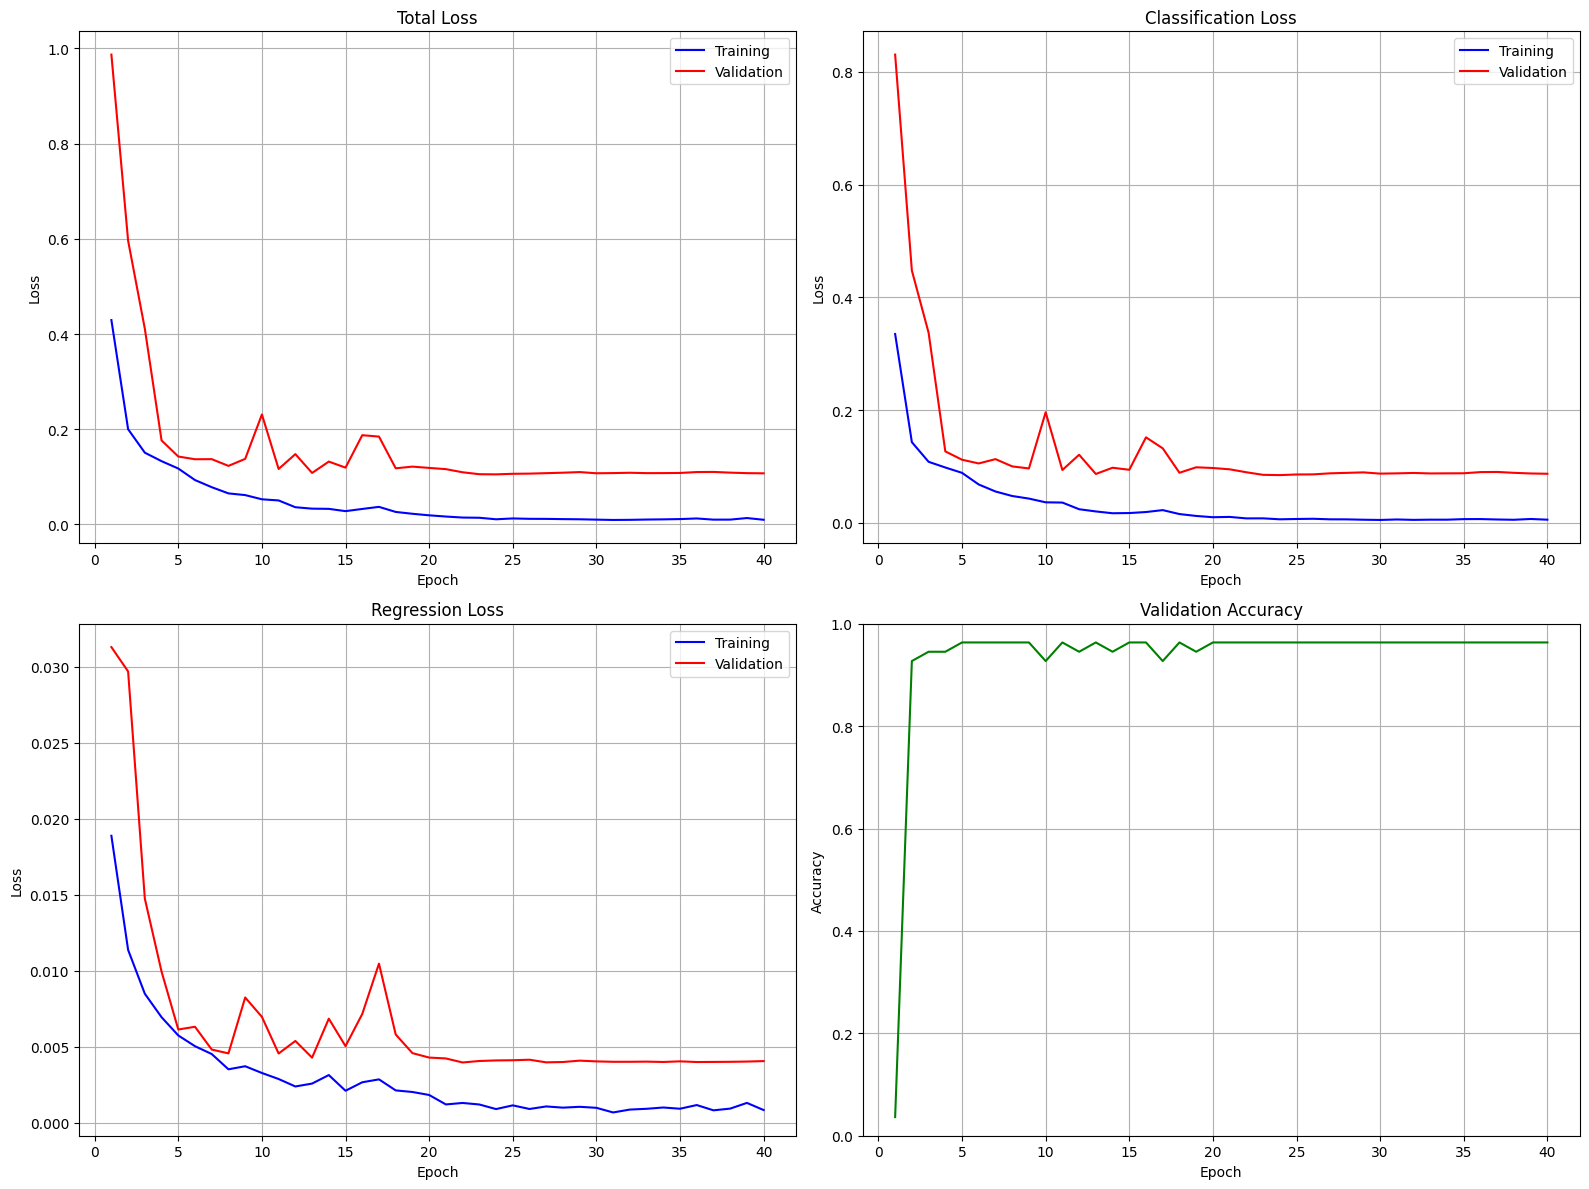

Model exported to TorchScript format for fast inference

Training complete!
To view TensorBoard logs, run:
tensorboard --logdir=runs


In [39]:
import os
import cv2
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from sklearn.model_selection import train_test_split
import time
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def train_model(csv_path, images_dir, epochs=40, batch_size=16, learning_rate=0.001):
    # Create lists to store metrics for plotting
    train_losses = []
    train_cls_losses = []
    train_reg_losses = []
    val_losses = []
    val_cls_losses = []
    val_reg_losses = []
    val_accuracies = []
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Define transformations
    train_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    val_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Split data and create datasets/loaders (your existing code)
    df = pd.read_csv(csv_path, header=None)
    train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df[0])
    
    train_csv = 'train_annotations.csv'
    val_csv = 'val_annotations.csv'
    train_df.to_csv(train_csv, index=False, header=False)
    val_df.to_csv(val_csv, index=False, header=False)
    
    train_dataset = LBendDataset(train_csv, images_dir, transform=None)
    val_dataset = LBendDataset(val_csv, images_dir, transform=None)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    
    # Initialize model, loss functions and optimizer
    model = CNNDetector().to(device)
    classification_loss = nn.BCELoss()
    regression_loss = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
    
    # Create a figure for real-time plotting
    plt.figure(figsize=(12, 10))
    plt.ion()  # Turn on interactive mode
    
    best_val_loss = float('inf')
    best_model_state = None
    
    # Training loop
    for epoch in range(epochs):
        model.train()
        train_cls_loss = 0.0
        train_reg_loss = 0.0
        train_loss = 0.0
        
        # Training phase
        for images, labels, centroids in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            centroids = centroids.to(device)
            
            optimizer.zero_grad()
            class_output, centroid_output = model(images)
            
            cls_loss = classification_loss(class_output.squeeze(), labels.squeeze())
            reg_loss = regression_loss(centroid_output, centroids)
            
            loss = cls_loss + 5.0 * reg_loss
            
            loss.backward()
            optimizer.step()
            
            train_cls_loss += cls_loss.item()
            train_reg_loss += reg_loss.item()
            train_loss += loss.item()
        
        # Calculate average training loss
        train_cls_loss /= len(train_loader)
        train_reg_loss /= len(train_loader)
        train_loss /= len(train_loader)
        
        # Store training metrics
        train_losses.append(train_loss)
        train_cls_losses.append(train_cls_loss)
        train_reg_losses.append(train_reg_loss)
        
        # Validation phase
        model.eval()
        val_cls_loss = 0.0
        val_reg_loss = 0.0
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for images, labels, centroids in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                centroids = centroids.to(device)
                
                # Forward pass
                cls_output, centroid_output = model(images)
                
                # Calculate losses
                cls_loss = classification_loss(cls_output, labels)
                reg_loss = regression_loss(centroid_output, centroids)
                loss = cls_loss + 5.0 * reg_loss
                
                # Accumulate validation loss
                val_cls_loss += cls_loss.item()
                val_reg_loss += reg_loss.item()
                val_loss += loss.item()
                
                # Calculate accuracy
                predicted = (cls_output > 0.5).float()
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
        
        # Calculate average validation metrics
        val_cls_loss /= len(val_loader)
        val_reg_loss /= len(val_loader)
        val_loss /= len(val_loader)
        accuracy = correct / total
        
        # Store validation metrics
        val_losses.append(val_loss)
        val_cls_losses.append(val_cls_loss)
        val_reg_losses.append(val_reg_loss)
        val_accuracies.append(accuracy)
        
        # Update learning rate based on validation loss
        scheduler.step(val_loss)
        
        # Print epoch results
        print(f"Epoch {epoch+1}/{epochs}")
        print(f"Train Loss: {train_loss:.4f} (Cls: {train_cls_loss:.4f}, Reg: {train_reg_loss:.4f})")
        print(f"Val Loss: {val_loss:.4f} (Cls: {val_cls_loss:.4f}, Reg: {val_reg_loss:.4f})")
        print(f"Accuracy: {accuracy:.4f}")
        
        
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
            print("Saved best model!")
            
            # Save model checkpoint
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_loss,
                'val_accuracy': accuracy,
                'train_losses': train_losses,
                'val_losses': val_losses,
                'train_cls_losses': train_cls_losses,
                'val_cls_losses': val_cls_losses,
                'train_reg_losses': train_reg_losses,
                'val_reg_losses': val_reg_losses,
                'val_accuracies': val_accuracies
            }, 'best_lbend_model.pth')
    
    # Final plot (non-interactive)
    plt.ioff()
    plt.figure(figsize=(16, 12))
    
    # Plot final losses
    plt.subplot(2, 2, 1)
    plt.plot(range(1, epochs+1), train_losses, 'b-', label='Training')
    plt.plot(range(1, epochs+1), val_losses, 'r-', label='Validation')
    plt.title('Total Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    
    # Plot final classification losses
    plt.subplot(2, 2, 2)
    plt.plot(range(1, epochs+1), train_cls_losses, 'b-', label='Training')
    plt.plot(range(1, epochs+1), val_cls_losses, 'r-', label='Validation')
    plt.title('Classification Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    
    # Plot final regression losses
    plt.subplot(2, 2, 3)
    plt.plot(range(1, epochs+1), train_reg_losses, 'b-', label='Training')
    plt.plot(range(1, epochs+1), val_reg_losses, 'r-', label='Validation')
    plt.title('Regression Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    
    # Plot final validation accuracy
    plt.subplot(2, 2, 4)
    plt.plot(range(1, epochs+1), val_accuracies, 'g-')
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.ylim(0, 1)
    
    plt.tight_layout()
    plt.savefig('final_training_results.png', dpi=200)
    plt.show()
    
    # Clean up temporary CSV files
    os.remove(train_csv)
    os.remove(val_csv)
    
    # Load the best model state
    if best_model_state:
        model.load_state_dict(best_model_state)
    
    # Export to TorchScript for faster inference
    model.eval()
    example = torch.rand(1, 3, 64, 64).to(device)
    traced_model = torch.jit.trace(model, example)
    traced_model.save('lbend_detector_scripted.pt')
    print("Model exported to TorchScript format for fast inference")
    
    # Return the trained model and metrics for further analysis
    return model, {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_cls_losses': train_cls_losses,
        'val_cls_losses': val_cls_losses,
        'train_reg_losses': train_reg_losses,
        'val_reg_losses': val_reg_losses,
        'val_accuracies': val_accuracies
    }

if __name__ == "__main__":
    csv_path = "labels_my-project-name_2025-07-02-05-15-40.csv"
    images_dir = "cropped_l_bends"
    model = train_model(csv_path, images_dir)
    
    print("\nTraining complete!")
    print("To view TensorBoard logs, run:")
    print("tensorboard --logdir=runs")

Using device: cuda
Loaded model checkpoint (val_loss: 0.10522903501987457)

--- CLASSIFICATION METRICS ---
              precision    recall  f1-score   support

  Not L-bend       0.00      0.00      0.00         2
      L-bend       0.96      1.00      0.98        53

    accuracy                           0.96        55
   macro avg       0.48      0.50      0.49        55
weighted avg       0.93      0.96      0.95        55

Confusion Matrix:
[[ 0  2]
 [ 0 53]]

--- CENTROID PREDICTION ERROR ---
Mean Error (normalized): 0.0704
Median Error (normalized): 0.0555
Min Error: 0.0053
Max Error: 0.2519

--- INFERENCE TIME ---
Average inference time per image: 0.06 ms
Theoretical max FPS: 16003.1


c:\Users\ROG\miniconda3\envs\pytorch_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ROG\miniconda3\envs\pytorch_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ROG\miniconda3\envs\pytorch_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

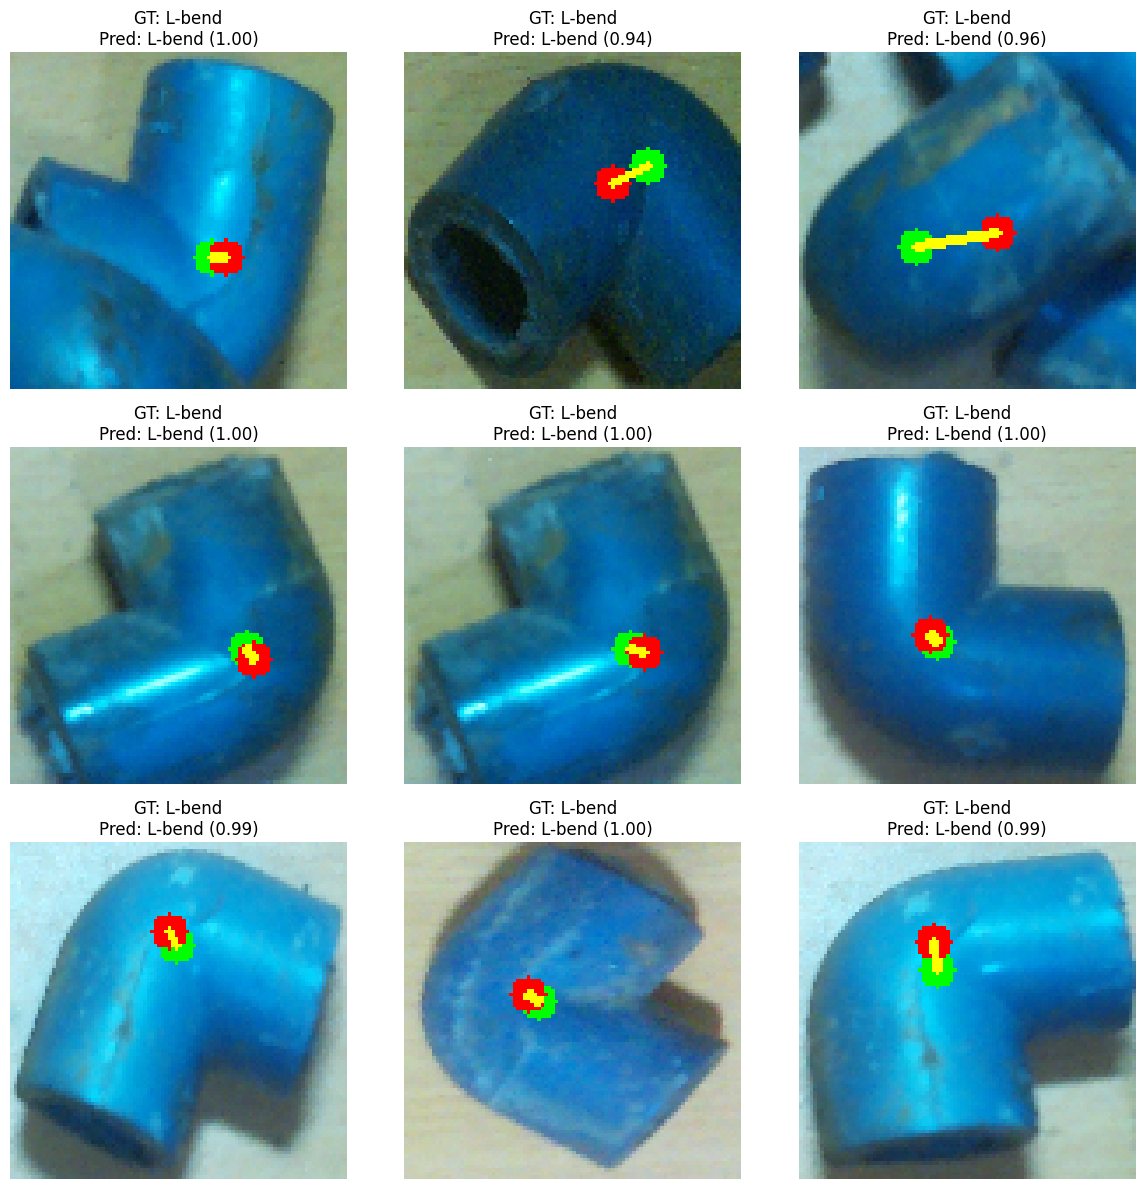

In [40]:
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
import time
from torch.utils.data import DataLoader
from torchvision import transforms
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Import your model and dataset class
# Change 'lbend_model' to your actual filename if different

def evaluate_model(model_path, csv_path, images_dir):
    """
    Comprehensive evaluation of the model with:
    - Classification metrics
    - Centroid prediction error
    - Inference time
    - Visualization
    
    Args:
        model_path: Path to trained model checkpoint
        csv_path: Path to annotation CSV
        images_dir: Directory containing images
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Load model
    if model_path.endswith('.pt'):
        # Load TorchScript model
        model = torch.jit.load(model_path, map_location=device)
        print("Loaded TorchScript model")
    else:
        # Load PyTorch checkpoint
        model = CNNDetector().to(device)
        checkpoint = torch.load(model_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f"Loaded model checkpoint (val_loss: {checkpoint.get('val_loss', 'N/A')})")
    
    model.eval()
    
    # Create validation dataset
    val_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Split data to get validation set
    df = pd.read_csv(csv_path, header=None)
    train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df[0])
    
    # Save val CSV temporarily
    val_csv = 'temp_val.csv'
    val_df.to_csv(val_csv, index=False, header=False)
    
    # Create dataset and loader
    val_dataset = LBendDataset(val_csv, images_dir, transform=None)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)  # Larger batch for faster evaluation
    
    # Collect predictions and ground truth
    all_preds = []
    all_labels = []
    all_centroid_errors = []
    inference_times = []
    
    with torch.no_grad():
        for image, label, centroid in val_loader:
            image = image.to(device)
            label = label.to(device)
            centroid = centroid.to(device)
            
            # Measure inference time
            start_time = time.time()
            pred_class, pred_centroid = model(image)
            inference_times.append(time.time() - start_time)
            
            # Classification results
            pred_label = (pred_class > 0.5).float()
            all_preds.extend(pred_label.cpu().numpy())
            all_labels.extend(label.cpu().numpy())
            
            # Centroid error
            centroid_error = torch.sqrt(((pred_centroid - centroid) ** 2).sum(dim=1)).cpu().numpy()
            all_centroid_errors.extend(centroid_error)
    
    # 1. Classification Report
    all_preds = np.array(all_preds).flatten()
    all_labels = np.array(all_labels).flatten()
    
    print("\n--- CLASSIFICATION METRICS ---")
    print(classification_report(all_labels, all_preds, target_names=['Not L-bend', 'L-bend']))
    
    cm = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:")
    print(cm)
    
    # 2. Centroid Error Analysis
    all_centroid_errors = np.array(all_centroid_errors)
    
    print("\n--- CENTROID PREDICTION ERROR ---")
    print(f"Mean Error (normalized): {np.mean(all_centroid_errors):.4f}")
    print(f"Median Error (normalized): {np.median(all_centroid_errors):.4f}")
    print(f"Min Error: {np.min(all_centroid_errors):.4f}")
    print(f"Max Error: {np.max(all_centroid_errors):.4f}")
    
    # 3. Inference Time Analysis
    avg_inference_time = np.mean(inference_times) / val_loader.batch_size  # Per image
    
    print("\n--- INFERENCE TIME ---")
    print(f"Average inference time per image: {avg_inference_time*1000:.2f} ms")
    print(f"Theoretical max FPS: {1/avg_inference_time:.1f}")
    
    # 4. Visualization of sample predictions
    visualize_samples(model, val_dataset, device, num_samples=9)
    
    # Clean up
    if os.path.exists(val_csv):
        os.remove(val_csv)

def visualize_samples(model, dataset, device, num_samples=9):
    """
    Visualize sample predictions with ground truth
    """
    indices = np.random.choice(len(dataset), min(num_samples, len(dataset)), replace=False)
    
    # Create figure
    num_cols = min(3, num_samples)
    num_rows = (num_samples + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 4*num_rows))
    if num_rows == 1 and num_cols == 1:
        axes = np.array([axes])
    axes = axes.flatten()
    
    for i, idx in enumerate(indices):
        if i >= len(axes):
            break
        
        # Get data
        image, label, centroid = dataset[idx]
        img_name = dataset.annotations.iloc[idx]['image_name']
        
        # Get original image (without normalization)
        img_path = os.path.join(dataset.images_dir, img_name)
        orig_img = cv2.imread(img_path)
        orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
        h, w = orig_img.shape[:2]
        
        # Forward pass
        with torch.no_grad():
            image_tensor = image.unsqueeze(0).to(device)
            pred_class, pred_centroid = model(image_tensor)
        
        # Convert to values
        gt_label = label.item()
        gt_centroid_x, gt_centroid_y = centroid[0].item(), centroid[1].item()
        pred_label = (pred_class > 0.5).float().item()
        pred_prob = pred_class.item()
        pred_centroid_x, pred_centroid_y = pred_centroid[0][0].item(), pred_centroid[0][1].item()
        
        # Convert normalized coordinates to pixel coordinates
        gt_x, gt_y = int(gt_centroid_x * w), int(gt_centroid_y * h)
        pred_x, pred_y = int(pred_centroid_x * w), int(pred_centroid_y * h)
        
        # Draw on image
        vis_img = orig_img.copy()
        
        # Draw centroids
        cv2.circle(vis_img, (gt_x, gt_y), 5, (0, 255, 0), -1)  # Ground truth (green)
        cv2.circle(vis_img, (pred_x, pred_y), 5, (255, 0, 0), -1)  # Prediction (red)
        
        # Draw connecting line
        cv2.line(vis_img, (gt_x, gt_y), (pred_x, pred_y), (255, 255, 0), 2)
        
        # Title
        title = f"GT: {'L-bend' if gt_label > 0.5 else 'Not L-bend'}\n"
        title += f"Pred: {'L-bend' if pred_label > 0.5 else 'Not L-bend'} ({pred_prob:.2f})"
        
        # Display
        axes[i].imshow(vis_img)
        axes[i].set_title(title)
        axes[i].axis('off')
    
    # Hide unused axes
    for j in range(i+1, len(axes)):
        axes[j].axis('off')
        
    plt.tight_layout()
    plt.savefig('model_evaluation.png', dpi=150)
    plt.show()

if __name__ == "__main__":
    model_path = "best_lbend_model.pth"  # or 'lbend_detector_scripted.pt'
    csv_path = "labels_my-project-name_2025-07-02-05-15-40.csv"
    images_dir = "cropped_l_bends"
    
    evaluate_model(model_path, csv_path, images_dir)

In [32]:
import cv2
import torch
import numpy as np
import time
from torchvision import transforms

def real_time_inference(model_path, camera_index=0, confidence_threshold=0.5):
    """
    Run real-time L-bend detection on webcam feed.
    
    Args:
        model_path: Path to the trained model (.pt or .pth)
        camera_index: Camera device index (default: 0 for primary webcam)
        confidence_threshold: Threshold for positive detection (default: 0.5)
    """
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Load model
    try:
        # Try loading as TorchScript model first (faster)
        model = torch.jit.load(model_path, map_location=device)
        print("Loaded TorchScript model")
    except:
        # Fall back to loading PyTorch checkpoint
        #from your_model_file import CNNDetector
        model = CNNDetector().to(device)
        checkpoint = torch.load(model_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        print("Loaded PyTorch checkpoint")
    
    model.eval()
    
    # Define transform
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Open camera
    cap = cv2.VideoCapture(camera_index)
    if not cap.isOpened():
        print(f"Error: Could not open camera {camera_index}")
        return
    
    # Get camera properties
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    # For FPS calculation
    fps = 0
    frame_times = []
    
    print("Press 'q' to quit")
    
    while True:
        # Start timing
        start_time = time.time()
        
        # Read frame
        ret, frame = cap.read()
        if not ret:
            print("Error: Failed to capture image")
            break
        
        # Convert to RGB (for preprocessing)
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # Preprocess
        input_tensor = transform(rgb_frame).unsqueeze(0).to(device)
        
        # Run inference
        with torch.no_grad():
            class_output, centroid_output = model(input_tensor)
        
        # Get results
        probability = class_output.item()
        is_lbend = probability > confidence_threshold
        
        # Convert normalized centroid coordinates back to original image
        centroid_x = int(centroid_output[0, 0].item() * frame_width)
        centroid_y = int(centroid_output[0, 1].item() * frame_height)
        
        # Draw results on frame
        if is_lbend:
            # Draw centroid
            cv2.circle(frame, (centroid_x, centroid_y), 5, (0, 255, 0), -1)
            
            # Draw box around detection
            box_size = min(frame_width, frame_height) // 8
            x1 = max(0, centroid_x - box_size)
            y1 = max(0, centroid_y - box_size)
            x2 = min(frame_width, centroid_x + box_size)
            y2 = min(frame_height, centroid_y + box_size)
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
            
            # Show confidence
            text = f"L-bend: {probability:.2f}"
            cv2.putText(frame, text, (x1, y1-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        
        # Calculate and display FPS
        process_time = time.time() - start_time
        frame_times.append(process_time)
        # Keep only the last 30 frames for averaging
        if len(frame_times) > 30:
            frame_times.pop(0)
        
        fps = 1.0 / (sum(frame_times) / len(frame_times))
        cv2.putText(frame, f"FPS: {fps:.1f}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2)
        
        # Display frame
        cv2.imshow('L-Bend Detector', frame)
        
        # Exit on 'q' key
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    
    # Release resources
    cap.release()
    cv2.destroyAllWindows()

if __name__ == "__main__":
    model_path = "lbend_detector_scripted.pt"  # Prefer TorchScript for faster inference
    real_time_inference(model_path, camera_index=0)

Using device: cuda
Loaded TorchScript model
Press 'q' to quit
